<a href="https://colab.research.google.com/github/Biline-dev/IARN/blob/main/TP1_IARN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier apperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Pour RNC
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
X.shape

(5000, 400)

In [4]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y = np.array([y if y != 10 else 0 for y in Y])
Y.shape

(5000,)

Afficher aléatoirement quelques données de notre base

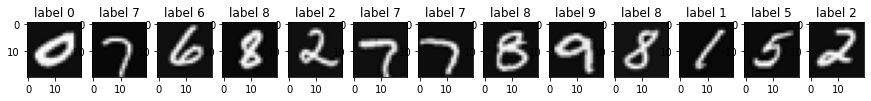

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de conusion

In [6]:
def confusion_matrix(Y, Y_pred, labels):
  conf_mat = []
  for i in labels:
    conf_mat_i = []
    for j in labels:
      count = predicted_from_class_x_but_from_class_y(Y, Y_pred, i, j)
      conf_mat_i.append(count)
    conf_mat.append(conf_mat_i)
  
  return conf_mat

- Rappel


In [7]:
def rappel(Y, Y_pred, labels):
  sumTauxVP = 0
  for label in labels:
    TP, _, TN, FN = confusion_matrix_i(Y, Y_pred, label)
    sumTauxVP += TP / (TP + FN)
  result = sumTauxVP / len(labels)
  return result

- Précision

In [8]:
def precision(Y, Y_pred, labels):
  sumPrecision = 0
  for label in labels:
    TP, FP, _, __ = confusion_matrix_i(Y, Y_pred, label)
    sumPrecision += TP / (TP + FP)
  result = sumPrecision / len(labels)
  return result

- Taux de FP

In [9]:
def tauxFP(Y, Y_pred, labels):
  sumTauxFP = 0
  for label in labels:
    _, FP, TN, FN = confusion_matrix_i(Y, Y_pred, label)
    sumTauxFP += FP / (FP + TN)
  result = sumTauxFP / len(labels)
  return result

- Spécificité

In [10]:
def specificite(Y, Y_pred, labels):
  sumSpecificite = 0
  for label in labels:
    _, FP, TN, __ = confusion_matrix_i(Y, Y_pred, label)
    sumSpecificite += TN / (FP + TN)
  result = sumSpecificite / len(labels)
  return result

- Courbe ROC

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [11]:
tRatio=2/3
ttRatio=1/3
# implementer la division

labels = np.unique(Y)

Partitionnement

In [12]:
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=ttRatio)

# Méthode 0: K- Plus Proches Voisins

### similarity functions

In [13]:
def euclidean(vector_1, vector_2):
    len_vector_1 = len(vector_1)
    len_vector_2 = len(vector_2)
    
    if len_vector_1 != len_vector_2:
        raise Exception("DIMENSION ERROR: vector_1 AND vector_2 DO NOT HAVE THE SAME DIMENSION")
    
    summation = 0
    for index in range(len_vector_1):
        summation += (vector_1[index] - vector_2[index]) ** 2
    
    result = np.sqrt(summation)
    return result

# hamming distance
def hamming(vector_1, vector_2):
    len_vector_1 = len(vector_1)
    len_vector_2 = len(vector_2)
    
    if len_vector_1 != len_vector_2:
        raise Exception("DIMENSION ERROR: vector_1 AND vector_2 DO NOT HAVE THE SAME DIMENSION")
    
    total = 0
    for index in range(len_vector_1):
        total += 1 if vector_1[index] != vector_2[index] else 0
    
    return total

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [14]:
def KPP(x, X_train, Y_train, K, similarity=euclidean):
    # is a list of (similarity, label)
    similarities = [(similarity(x, X_train[index]), Y_train[index]) for index in range(len(X_train))]
    
    # sort by similarity
    sorted_list = sorted(similarities, key=lambda x:x[0])
    
    # truncate and keep only k first values
    truncated_list = sorted_list[0:K]
    
    # deconstruct tuncated list [(x, y)] to [y]
    k_nearest_neighbors = [label for distance, label in truncated_list]
    
    # label selection portion
    min_count = 0
    for neighbor in k_nearest_neighbors:
        # count duplicates of neighbor
        current_count = k_nearest_neighbors.count(neighbor)
        min_count, label = (current_count, neighbor) if current_count > min_count else (min_count, neighbor)
    
    return label

# Méthode 1: MVS
Machine à Vecteurs de Support

In [15]:
model = svm.SVC(kernel='linear')
model.fit(Xt, Yt)
y_pred_svm = model.predict(Xtt)

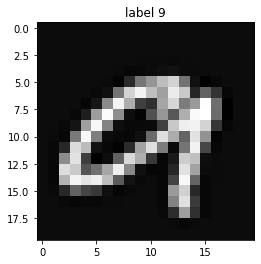

In [16]:
# tester une image
c = 3
y_pred_svm[c]
a = Xtt[c,:].reshape((20, 20))
a = np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a, cmap='gray')

# Méthode 2: Arbres de décision


In [17]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred_dt = model.predict(Xtt)

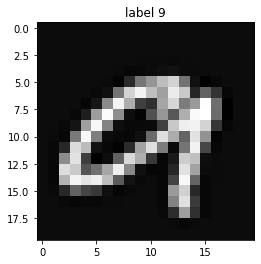

In [18]:
# tester une image
c= 3
y_pred_dt[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [59]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(200),max_iter=10_000_000)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=200, max_iter=10000000,
              solver='sgd')

In [60]:
y_pred_nn = model.predict(Xtt)

In [22]:
# pour ROC, il faudra les probabilités:
model.predict_proba([Xtt[c,:]])

array([[8.30314957e-01, 1.65865098e-17, 1.15840603e-09, 2.90474071e-02,
        5.35649905e-38, 1.40637600e-01, 9.12677405e-38, 2.39740108e-21,
        3.50238207e-08, 1.37772583e-19]])

Afficher l'image testée

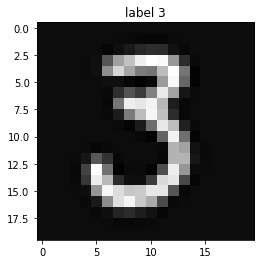

In [51]:
c = random.randint(Ytt.shape[0])
a = Xtt[c,:].reshape((20, 20))
a = np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

In [24]:
# reshape dataset to have a single channel
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [55]:
# Recoder le valeurs
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

Xt_rncN = Xt_rnc.astype('float32')
Xtt_rncN = Xtt_rnc.astype('float32')

# normaliser
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# evaluaer le modèle
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)


# Appliquer les métriques implementées pour voir le résultat

## Méthode 1: MVS

In [56]:
print(f"rappel MVS      = {rappel(Ytt, y_pred_svm, labels)}")
print(f"precision MVS   = {precision(Ytt, y_pred_svm, labels)}")
print(f"Taux FP MVS     = {tauxFP(Ytt, y_pred_svm, labels)}")
print(f"Specificite MVS = {specificite(Ytt, y_pred_svm, labels)}")

rappel MVS      = 0.9138951392803568
precision MVS   = 0.9147857967633847
Taux FP MVS     = 0.009750941501089544
Specificite MVS = 0.9902490584989104


## Méthode 2: DT

In [57]:
print(f"rappel DT      = {rappel(Ytt, y_pred_dt, labels)}")
print(f"precision DT   = {precision(Ytt, y_pred_dt, labels)}")
print(f"Taux FP DT     = {tauxFP(Ytt, y_pred_dt, labels)}")
print(f"Specificite DT = {specificite(Ytt, y_pred_dt, labels)}")

rappel DT      = 0.767208740191665
precision DT   = 0.7680347816217418
Taux FP DT     = 0.026165892505363542
Specificite DT = 0.9738341074946364


## Méthode 3: RN

In [61]:
print(f"rappel NN      = {rappel(Ytt, y_pred_nn, labels)}")
print(f"precision NN   = {precision(Ytt, y_pred_nn, labels)}")
print(f"Taux FP NN     = {tauxFP(Ytt, y_pred_nn, labels)}")
print(f"Specificite NN = {specificite(Ytt, y_pred_nn, labels)}")

rappel NN      = 0.8406618905765667
precision NN   = 0.8399824906134159
Taux FP NN     = 0.017713893593215752
Specificite NN = 0.9822861064067843


# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 4 Mars 2022 à 22h

La partie RNC peut être laissée pour le prochain TP

In [ ]:
# bonne chance

# Utility Functions

In [ ]:
def predicted_from_class_x_but_from_class_y(Y, Y_pred, x, y):
  if len(Y) != len(Y_pred):
    raise ValueError("Y and Y_pred do not have the same dimensions")
  
  count = 0
  for idx in range(len(Y)):
    count += 1 if Y_pred[idx] == x and Y[idx] == y else 0

  return count

In [ ]:
def confusion_matrix_i(Y, Y_pred, i):
  TP, FP, TN, FN = 0, 0, 0, 0
  for y, y_pred in zip(Y, Y_pred):
    if y == i and y_pred == i:
      TP += 1

    if y != i and y_pred == i:
      FP += 1

    if y != i and y_pred != i:
      TN += 1

    if y == i and y_pred != i:
      FN += 1
  
  return TP, FP, TN, FN